# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Notebook resume</div>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; margin-left: 30px">   
Throughout this notebook I'm going to use Pytorch to train a series of models for the Cassava Leaf competition, you can learn more about this competition here, <a href="https://www.kaggle.com/competitions/cassava-leaf-disease-classification">[link]</a>. At the beginning I had published a version with an approach where it was shown how to face the competition, I have changed it because it did not seem quite good to me. Now what I'm looking for is to achieve a good score, within the limits that Kaggle gives you with its GPU. For which I created a complete pipeline with Pytorch Lightning, which seems to me to be a very interesting framework, since it allows you to carry out experiments in a simple way, and combined with wieghts and biases, who it's very useful for tracking experiments.</p>

# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Table of Contents</div>

* [1-Libraries](#section-one)
* [2-Data loading](#section-two)
* [3-Preprocessing](#section-three)
    * [3.1-Target distribution](#subsection-three-one)
    * [3.2-Data splitting](#subsection-three-two)
* [4-Transfer learning with Timm and Pytorch Ligthning](#section-four)
    * [4.1-Dataset and Lightning Datamodule](#subsection-four-one)
    * [4.2-Batch testing](#subsection-four-two)
    * [4.3-Images checking](#subsection-four-three)
    * [4.4-Lightning Module](#subsection-four-four)
    * [4.5-Training](#subsection-four-five)
* [5-Predictions and Evaluation](#section-five)
    * [5.1-Inference](#subsection-five-one)
    * [5.2-Leaderboard results](#subsection-five-two)
* [6-Improvements and future work](#section-six)
* [7-References](#section-seven)

<a id="section-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 1 | Libraries</div>


In [ ]:
import os
import gc
from pathlib import Path
import random
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
 
import albumentations as A
import cv2

In [ ]:
plt.style.use('ggplot')

In [ ]:
sns.set_style('darkgrid')

<a id="section-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 2 | Data loading</div>


In [ ]:
files_path = '../input/cassava-leaf-disease-classification'

In [ ]:
path = Path(files_path)
os.listdir(path)

In [ ]:
train = pd.read_csv(path/'train.csv')

In [ ]:
train['path'] = f'{path}/train_images/' + train['image_id']

In [ ]:
test = pd.read_csv(path/'sample_submission.csv')

In [ ]:
test['path'] = f'{path}/test_images/' + test['image_id']

<a id="section-three"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 3 | Preprocessing</div>

<a id="subsection-three-one"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 3.1 | Target distribution</div>

In [ ]:
plt.figure(figsize=(10,5))
g = sns.histplot(data=train['label'], x=train.label, bins=5)
mids = [rect.get_x() + rect.get_width() / 2 for rect in g.patches]
g.set_xticks(mids)
g.set_xticklabels([0,1,2,3,4]);

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left: 30px">   
We can clearly see that the dataset labels are quite biased towards the class 3. </p>

In [ ]:
targets = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy",
           }

<a id="subsection-three-three"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 3.2 | Data splitting</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left: 30px">    
Since the classes are unbalanced, I'm going to use stratifiedkfold to split the data them into stratified folds, so that they have the same original distribution of classes. </p>

In [ ]:
def folds (df):
    df = df.copy()
    skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    df['kfold'] = -1
    for fold, (_, val_idx) in enumerate(skf.split(X = df, y = df['label'])):
        df.loc[val_idx, 'kfold'] = fold
    return df

In [ ]:
train = folds(train)

<a id="section-four"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:0px"> 4 | Transfer learning with Timm and Pytorch Lightning</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">   
In this part I'm going to make use of the timm library that has many models. And also a framework call Pytorch Lightning I found it super useful for this type of competition, since it allows you to experiment in an extremely simple way. </p>

In [ ]:
!pip install wandb -q < /dev/null

In [ ]:
!pip install wandb --upgrade -q < /dev/null

In [ ]:
!pip install timm -q  < /dev/null

In [ ]:
import timm

In [ ]:
timm.list_models(pretrained=True)
timm.list_models('*efficient*')[:10]

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">
Here you can see a list of some efficientnet models available in the timm library. </p>
    

<a id="subsection-four-one"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.1 | Dataset and Lightning Datamodule</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">
The DataModule of Pytorch Lightning it's reusable class that encapsulates all the steps needed to process data, In conjunction with the LightningModule, they are the two main objects of this framework. You can learn more about it here,  <a href="https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html?highlight=DataModule">[link]</a>  </p>

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

In [ ]:
class CassavaDataset(Dataset):
    
    def __init__(self, dataset, transforms=None):      
    
        self.image = dataset['image_id']
        self.labels = dataset['label']
        self.full_filenames = dataset['path']
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.full_filenames) 
      
    def __getitem__(self, idx):

        img = cv2.imread(self.full_filenames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
        if self.transforms:
            img = self.transforms(image=img)['image']
        img = torch.tensor(img, dtype=torch.float).permute(2,0,1)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return img, label

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, 
                 train=None,
                 valid=None,
                 test=None,
                 path=None, 
                 batch_size=64, 
                 train_trans=None, 
                 valid_trans=None,
                 test_trans=None,
                 num_workers=0,
                 pin_memory=False,
                 **kwargs):
        
        super().__init__()

        self.train = train
        self.valid = valid
        self.test = test
        self.path = path
        self.train_trans = train_trans
        self.valid_trans = valid_trans
        self.test_trans = test_trans
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def setup(self, stage=None):

        if stage == "train" or stage is None:
            
            train = self.train
            valid = self.valid
                
            train_images = [str(self.path/'train_images'/img) for img in self.train['image_id'].values]
            train_labels = self.train['label'].values

            valid_images = [str(self.path/'train_images'/img) for img in self.valid['image_id'].values]
            valid_labels = self.valid['label'].values

            print("Training samples: ", len(self.train))
            print("Validation samples: ", len(self.valid))
    
            # train dataset
            self.train_ds = CassavaDataset(
                train,
                transforms = A.Compose([getattr(A, trans)(**params) for trans, params in self.train_trans.items() ]) if self.train_trans else None)

            # valid dataset
            self.valid_ds=CassavaDataset(
                valid,
                transforms = A.Compose([getattr(A, trans)(**params) for trans, params in self.valid_trans.items()]) if self.valid_trans else None)
            
        if stage == "test":
            
            test_images = [str(self.path/'test_images'/img) for img in self.test['image_id'].values]
            test_labels = self.test['label'].values
            
            if self.test is not None:
                # test dataset
                self.test_ds = CassavaDataset(self.test,
                                              transforms = A.Compose([getattr(A, trans)(**params) for trans, params in self.test_trans.items()]) if self.test_trans else None)

            else:
                self.test_ds = CassavaDataset(valid, 
                                              transforms = A.Compose([getattr(A, trans)(**params) for trans, params in self.valid_trans.items()]) if self.valid_trans else None)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, pin_memory=self.pin_memory)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, pin_memory=self.pin_memory)
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, pin_memory=self.pin_memory)

<a id="subsection-four-two"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.2 | Batch testing</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">   
I feel that it is a good practice to check what the dataloader batch is returning to you to avoid any type of problem in another stage of the process.</p>

In [ ]:
xtrain= train[train.kfold !=0].reset_index(drop=True)
xvalid= train[train.kfold ==0].reset_index(drop=True)

In [ ]:
size=512
train_trans={
        'RandomResizedCrop':
            {'width': size,
             'height': size},
        'Transpose': {'p':.5},
        'HorizontalFlip':{},
        'ShiftScaleRotate':{'p':0.2},
        'CoarseDropout':{'p':0.5},
            }

valid_trans={
          'CenterCrop': 
                {'width': size,
                 'height': size},
          'Resize':
            {'width': size,
             'height': size}
            }

In [ ]:
dm=DataModule(train=xtrain,
              valid=xvalid,
              path=path,
              train_trans=train_trans, 
              valid_trans=valid_trans)

In [ ]:
dm.setup(stage='train')

In [ ]:
train_dl = dm.train_dataloader()

In [ ]:
imgs, labels = next(iter(train_dl))

In [ ]:
imgs.shape, labels.shape

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">   
Here we can see that everything works as we specify, we have a batch of 64 images, with a size of 512x512 each, and the labels are 64 as well.</p>

<a id="subsection-four-three"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.3 | Images checking</div>

In [ ]:
def show_sample(img, target, invert=None):
    plt.figure (figsize=(7,7))
    
    for k, v in targets.items():
            if k == target:
                print(f'Label = {v} and Target = {target}')
    print()

    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))

In [ ]:
plt.rc('font', size=9)
def test_transforms(one_sample=False, dataset=None, sample_number=None):
    """
    Test a random number of samples or just a single image sample to check how the transformations works.
    Args:
    one_sample = boolean,
    dataset = torch dataset,
    sample_number = a custom index to check a single image multiple times, otherwise random number to check a batch
    """
    r, c = 3, 5
    fig = plt.figure(figsize=(4*c, 4*r))

    for _r in range(r):
        for _c in range(c):
            ax = plt.subplot(r, c, _r*c + _c + 1)

            if one_sample:
                ix=sample_number    
            else:
                ix = random.randint(0, len(train_dataset))

            img, label = dataset[ix]
            label_name = [l for c, l in targets.items() if c == label]

            plt.axis("off")
            plt.imshow(img.permute(1,2,0))
            plt.title(f'{label} {label_name}', loc='center')
    plt.tight_layout()
    plt.show()

In [ ]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

In [ ]:
train_dataset = dm.train_ds

In [ ]:
show_sample(train_dataset[0][0], train_dataset[0][1])

In [ ]:
test_transforms(one_sample=False, dataset=train_dataset, sample_number=None)

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">   
With this function we can see some of the transformations that we applied previously, I feel that doing this is good to see that they make sense, since there are many. </p>

In [ ]:
test_transforms(one_sample=True, dataset=train_dataset, sample_number=2)

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">   
If you wish, with the same function you can check the different transformations applied to the same image, in this case image number 2 of the dataset.</p>

In [ ]:
show_batch(train_dl)

<p style="font-size:18px; font-family:verdana; line-height: 1.7em; margin-left:30px">  
With show batch we can see the entire batch of images that we are going to give to the neural network at the time of training.</p>

<a id="subsection-four-four"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.4 | Ligthning Module</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
Lightning module is one of the 2 main objects of this framework, as you can see it is very similar to how we define the models in pure Pytorch, but with some extra features. You can read more about it here  <a href="https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html">[link]</a></p>

In [ ]:
class Model(pl.LightningModule):

    def __init__(self, model, lr= 3e-4, optimizer='Adam', scheduler=None):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = timm.create_model(self.hparams.model, pretrained=True)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 5)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        val_acc = accuracy(y_hat, y)
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc, prog_bar=True)
        return {'val_loss':val_loss, 'val_acc':val_acc }

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer)(self.parameters(), lr=self.hparams.lr)
        if self.hparams.scheduler:
            schedulers = [
                getattr(torch.optim.lr_scheduler, scheduler)(optimizer, **params)
                for scheduler, params in self.hparams.scheduler.items()
            ]
            return [optimizer], schedulers 
        return optimizer

    def forward(self, x):
        return self.backbone(x)

<a id="subsection-four-five"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.5 | Training</div>


In [ ]:
# Configuration
model_name = 'tf_efficientnet_b3_ns'
epochs = 15
lr = 3e-4
opt_func = 'Adam'
scheduler1={
    'OneCycleLR':
           {'pct_start': 0.1,
            'max_lr': 0.01,
            'total_steps': 50,
            'verbose': False}
            }
scheduler2={
'CosineAnnealingWarmRestarts':
    {'T_0':10, 
     'T_mult':1, 
     'eta_min':1e-6, 
     'last_epoch':-1
    }
            }

size = 512
train_trans={
        'RandomResizedCrop':
            {'width': size,
             'height': size},
        'Transpose': {'p':.5},
        'HorizontalFlip':{},
        'ShiftScaleRotate':{'p':0.2},
        'CoarseDropout':{'p':0.5},
            }

valid_trans={
          'CenterCrop': 
                {'width': size,
                 'height': size},
          'Resize':
            {'width': size,
             'height': size}
            }

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"

In [ ]:
for fold in range(3):
    print(f'fold n={fold}')
    
    pl.seed_everything(fold)
    xtrain= train[train.kfold != fold].reset_index(drop=True)
    xvalid= train[train.kfold == fold].reset_index(drop=True)
    
    dm = DataModule(train=xtrain, 
                    valid=xvalid,
                    path=path,
                    subset=0,
                    batch_size=32,
                    num_workers=2,
                    pin_memory=True,
                    train_trans=train_trans, 
                    valid_trans=valid_trans)

    dm.setup(stage='train')

    model = Model(model=model_name, scheduler=scheduler2)
    
    es = EarlyStopping(monitor='val_acc', mode='max', patience=3)
    checkpoint = ModelCheckpoint(dirpath='./', filename=f'{model_name}-{size}-fold={fold}-{{val_acc:.5f}}', save_top_k=1, monitor='val_acc', mode='max')
    
    wandb_logger = WandbLogger(project="Cassava", name=f"{model_name}-{fold}")
    trainer = pl.Trainer(gpus=1,
                         precision=16,
                         max_epochs=epochs,
                         logger=wandb_logger,
                         callbacks=[es, checkpoint],
                         deterministic=True)
    trainer.fit(model, dm)
    wandb_logger.experiment.finish()

<a id="subsection-four-five"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 4.6 | Experiment tracking with Weights and Biases</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
Through Weights and Biases you can follow or track your runs in a simple and super visual way, below I share a screenshot of the current experiment, I recently discovered this tool and it seems super useful. </p>

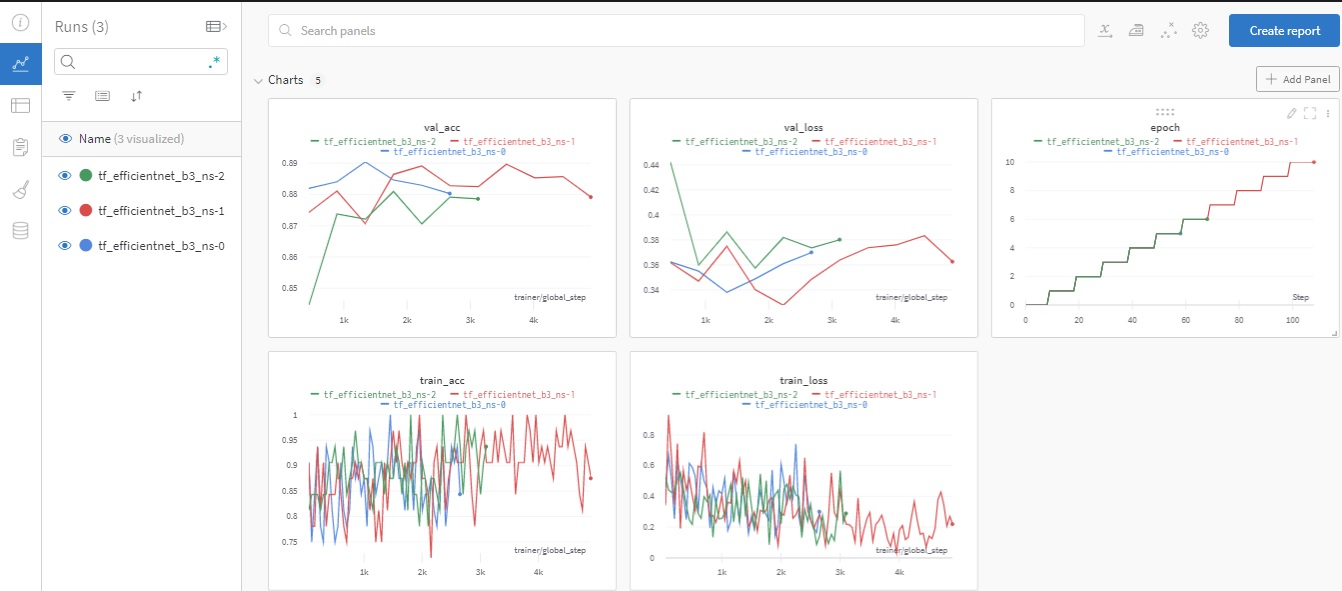

<a id="section-five"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 5 | Predictions and Evaluation </div>

<a id="subsection-five-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 5.1 | Inference </div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
To make predictions, the best way to do it it's in a separate notebook, to avoid having to retrain the model, and just do the inference. For which you have to upload the models to Kaggle, and also the timm library (if you use it). Below I share an inference example for this competition.</p>

In [ ]:
ckpt_path='./'

In [ ]:
ckpt_path = Path(ckpt_path)
ckpt_path

In [ ]:
models_path=list(ckpt_path.glob("*.ckpt"))
models_path

In [ ]:
test_trans={
    'RandomCrop': 
        {'height': size, 
         'width': size},
    'HorizontalFlip': {},
    'Resize':
            {'width': size,
             'height': size}}    

In [ ]:
dm = DataModule(test=test,
                path=path,
                batch_size=32,
                test_trans=test_trans)
    
dm.setup(stage='test')
test_dataloader = dm.test_dataloader()

In [ ]:
def predict(models_path, dl, device):   
    
    fin_preds = []
    for path in tqdm(models_path):
        model = Model.load_from_checkpoint(path)
        model.eval()
        model.to(device)   
        preds = torch.tensor([]).to(device)
        with torch.no_grad():
            for i, l in dl:
                i = i.to(device)
                y_hat = model(i)
                preds = torch.cat([preds, y_hat])
        fin_preds.append(preds)
    fin_preds = torch.stack(fin_preds).mean(axis=0)
    return torch.argmax(fin_preds, axis=1).cpu().numpy()

In [ ]:
preds = predict(models_path, test_dataloader, 'cuda')

In [ ]:
test_df = test[['image_id', 'label']].copy()
test_df['label'] = preds

In [ ]:
test_df.to_csv('submission.csv', index=False)

<a id="subsection-five-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#303030;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%;margin-left:10px"> 5.2 | Leaderboard results </div>

> 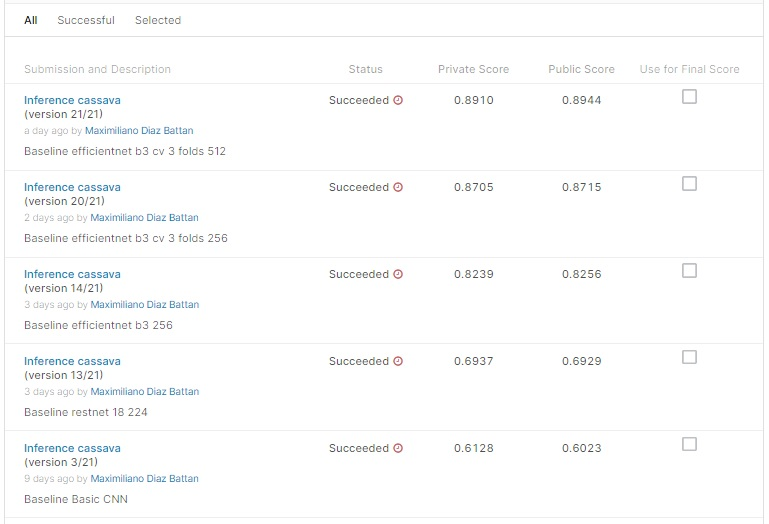

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
Here we can see the different submissions, from a basic CNN, to an ensemble of 3 folds with efficientnet b3 with 512x512 images. You can see how the ensemble allows us to jump from 0.82 to 0.87.  And in the last run, with the same efficientnet b3 but with images of 512x512, we are in the top 5% with a score of 0.891. 
</p>

<a id="section-six"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 6 | Improvements and future work</div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
There's room to improve the models, some ideas can be taken from the winning solutions, from here we can see that, among the most important things is the ensemble, also add extra data and pseudolabeling, larger architectures, among other things. In the following updates I'll be doing some of this. Below I share the top 3 solutions: </p>

> * <a href="https://www.kaggle.com/competitions/cassava-leaf-disease-classification/discussion/221957"> First place</a>
> * <a href="https://www.kaggle.com/competitions/cassava-leaf-disease-classification/discussion/220898"> Seconde place</a>
> * <a href="https://www.kaggle.com/competitions/cassava-leaf-disease-classification/discussion/221150"> Third place</a>

<a id="section-seven"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 7 | References </div>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
As for references, I leave the pytorch, pytorch lightning, and weights and biases documentation, a discussion of mine with information about courses and materials to learn deep learning. </p>

> * <a href="https://pytorch.org/docs/stable/index.html"> Pytorch docs</a>
> * <a href="https://pytorch-lightning.readthedocs.io/en/latest/"> Pytorch Lightning docs</a>
> * <a href="https://docs.wandb.ai/"> Weights and Biases docs</a>
> * <a href="https://www.kaggle.com/competitions/tabular-playground-series-nov-2021/discussion/288064"> Pytorch courses and materials</a>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:30px;"> 
<b>Ps</b>, If you know spanish, a good place to learn is the Juan Sensio youtube channel, <a href="https://www.youtube.com/c/sensio-ia">[link].</a> </p>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em;background-color: white; border-radius: 5px;margin-left:20px;"> 
Thank you very much for taking the time to read my notebook. Greetings!</p>